<a href="https://colab.research.google.com/github/FunctionFreak/Price-Prediction/blob/main/Taxi_price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Model to predict price.
1.   Approach:  Random Forrest and GBT regression
2.   Approach: Decision Tree Regression
   


# **Initiate and Configure Spark**

In [1]:
# Install required libraries
!pip install pandas
!pip install matplotlib
!pip install pyspark
!pip install seaborn
# Import necessary modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Imputer, StringIndexer
from pyspark.sql.functions import hour, dayofweek, col, when
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.sql.functions import abs as abs_spark
import numpy as np
from pyspark.ml.feature import StandardScaler
#model selection 1st
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# model selection 2nd
from pyspark.ml.regression import DecisionTreeRegressor
#model selection 3rd
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
from pyspark.ml.tuning import TrainValidationSplit
import seaborn as sns
#spark session
from pyspark.sql import SparkSession

# Creating Spark session
spark = SparkSession.builder \
    .appName("group_10") \
    .config("spark.some.config.option","16") \
    .getOrCreate()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=457fb662dac6ddbd058c9c620e60fd95ffecba13182618734c81f586e5e6d3f3
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


---
# **Task 1 - Data Loading and Preprocessing **
---

In [ ]:

drive.mount('/content/drive')
base_path = '/content/drive/My Drive/taxifare/'

# Define columns to be read
columns = ['tpep_pickup_datetime',
           'tpep_dropoff_datetime',
           'trip_distance',
           'pickup_longitude',
           'pickup_latitude',
           'dropoff_longitude',
           'dropoff_latitude',
           'passenger_count',
           'RateCodeID',
           'store_and_fwd_flag',
           'fare_amount',
            'extra',
            'mta_tax',
            'tolls_amount',
            'improvement_surcharge',
            'total_amount']

# Read CSV files into DataFrames
taxifare= spark.read.csv(f'{base_path}yellow_tripdata_2015-01.csv', header=True, inferSchema=True).select(columns).limit(100000)
taxifare = taxifare.withColumnRenamed("tpep_pickup_datetime", "pickup_time") \
                   .withColumnRenamed("tpep_dropoff_datetime", "dropoff_time")

# Show DataFrames
taxifare.show()

#data cleaning and preproccessing
def clean_data(taxifare, test=False, predict=False):
    # Filter out rows with dropoff latitude or longitude not equal to 0
    taxifare = taxifare.filter((col("dropoff_latitude") != 0) | (col("dropoff_longitude") != 0))

    # Filter out rows with pickup latitude or longitude not equal to 0
    taxifare = taxifare.filter((col("pickup_latitude") != 0) | (col("pickup_longitude") != 0))

    return taxifare
taxifare = clean_data(taxifare)

# Convert string column to numerical using StringIndexer to deal with store_and_fwd_flag coloumn value
string_indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_flag_index")
taxifare = string_indexer.fit(taxifare).transform(taxifare)
# Filter out rows with null values in the indexed column
taxifare = taxifare.filter(col("store_and_fwd_flag_index").isNotNull())
# Remove original string column
taxifare = taxifare.drop("store_and_fwd_flag")
# Define columns to impute (excluding pickup_time and dropoff_time)
columns_to_impute = [col_name for col_name in taxifare.columns if col_name not in ['pickup_time', 'dropoff_time']]
# Create Imputer object
imputer = Imputer(inputCols=columns_to_impute, outputCols=columns_to_impute)
# Fit and transform the data
imputer_model = imputer.fit(taxifare)
taxifare = imputer_model.transform(taxifare)


# Filter out rows where trip_distance is less than 0.9
taxifare_filtered = taxifare.filter(col('trip_distance') >= 0.9)

#performing feature engineering
# Step 1: Extract hour of the day from pickup time
taxifare_filtered = taxifare_filtered.withColumn("pickup_hour", hour("pickup_time"))
# Step 2: Extract day of the week from pickup time
taxifare_filtered = taxifare_filtered.withColumn("pickup_dayofweek", dayofweek("pickup_time"))
# Step 3: Calculate trip duration
taxifare_filtered = taxifare_filtered.withColumn("trip_duration", (col("dropoff_time").cast("long") - col("pickup_time").cast("long")) / 60)
# Step 4: Create distance-related features (e.g., Manhattan distance)
taxifare_filtered = taxifare_filtered.withColumn("manhattan_distance",
                                                 (col("dropoff_longitude") - col("pickup_longitude")) +
                                                 (col("dropoff_latitude") - col("pickup_latitude")))
# Step 5: Create categorical feature for time of day
taxifare_filtered = taxifare_filtered.withColumn("time_of_day",
                                                 when((col("pickup_hour") >= 5) & (col("pickup_hour") < 12), "morning")
                                                 .when((col("pickup_hour") >= 12) & (col("pickup_hour") < 17), "afternoon")
                                                 .when((col("pickup_hour") >= 17) & (col("pickup_hour") < 21), "evening")
                                                 .otherwise("night"))
# Step 6: Create binary feature for weekend trips
taxifare_filtered = taxifare_filtered.withColumn("pickup_weekend",
                                                 (col("pickup_dayofweek") == 1) | (col("pickup_dayofweek") == 7))

## Create a StringIndexer for time_of_day column
indexer = StringIndexer(inputCol="time_of_day", outputCol="time_of_day_index")
# Apply StringIndexer to the DataFrame
taxifare_indexed = indexer.fit(taxifare_filtered).transform(taxifare_filtered)
# Define the updated feature columns after indexing time_of_day
feature_columns_updated = ['trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                           'passenger_count', 'pickup_hour', 'pickup_dayofweek', 'trip_duration', 'manhattan_distance',
                           'time_of_day_index', 'pickup_weekend']
# Create a VectorAssembler object
assembler = VectorAssembler(inputCols=feature_columns_updated, outputCol="features")
# Apply the VectorAssembler to the DataFrame
taxifare_assembled = assembler.transform(taxifare_indexed)
# Show the DataFrame with the assembled features
taxifare_assembled.select("features").show(truncate=False)

# Split the data into training and testing sets (70% training, 30% testing)
train_data, test_data = taxifare_assembled.randomSplit([0.7, 0.3], seed=42)

# Get counts of training and testing data
training_count = train_data.count()
test_count = test_data.count()





+-------------------+-------------------+-------------+------------------+------------------+------------------+------------------+---------------+----------+------------------+-----------+-----+-------+------------+---------------------+------------+
|        pickup_time|       dropoff_time|trip_distance|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|RateCodeID|store_and_fwd_flag|fare_amount|extra|mta_tax|tolls_amount|improvement_surcharge|total_amount|
+-------------------+-------------------+-------------+------------------+------------------+------------------+------------------+---------------+----------+------------------+-----------+-----+-------+------------+---------------------+------------+
|2015-01-15 19:05:39|2015-01-15 19:23:42|         1.59|  -73.993896484375|  40.7501106262207|-73.97478485107422| 40.75061798095703|              1|         1|                 N|       12.0|  1.0|    0.5|         0.0|                  0.3|      

---
# **Task 2 - Model Selection and Implementation**
---


In [ ]:
## 1st approach I deployed both the Random Forest and Gradient Boosting Tree (GBT) models as ensemble learners
#to predict the fare_amount. I'm particularly computing the RMSE score since the purpose is to forecast a continuous target variable,
 # especially the ticket amount. RMSE is especially suited for regression applications involving continuous outputs,
# as it measures the average disparity between expected and actual values.

rf = RandomForestRegressor(featuresCol="features", labelCol="fare_amount")
# Create a pipeline for the Random Forest model
rf_pipeline = Pipeline(stages=[rf])
# Fit the Random Forest model
rf_model = rf_pipeline.fit(train_data)
# Make predictions using the Random Forest model
rf_predictions = rf_model.transform(test_data)
# Evaluate the Random Forest model
rf_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rf_rmse = rf_evaluator.evaluate(rf_predictions)
# Print the RMSE of the Random Forest model
print("Random Forest - Root Mean Squared Error (RMSE) on test data:", rf_rmse)

#GBTRegression
gbt = GBTRegressor(featuresCol="features", labelCol="fare_amount")
# Create a pipeline for the GBT Regression model
gbt_pipeline = Pipeline(stages=[gbt])
# Fit the GBT Regression model
gbt_model = gbt_pipeline.fit(train_data)
# Make predictions using the GBT Regression model
gbt_predictions = gbt_model.transform(test_data)
# Evaluate the GBT Regression model
gbt_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions)
# Print the RMSE of the GBT Regression model
print("GBT Regression - Root Mean Squared Error (RMSE) on test data:", gbt_rmse)

# Block 3: Combined Model (Stacked Model) with Linear Regression

# Rename prediction columns to distinguish between base models
rf_predictions = rf_predictions.withColumnRenamed("prediction", "rf_prediction")
gbt_predictions = gbt_predictions.withColumnRenamed("prediction", "gbt_prediction")
# Combine predictions with the original target column
combined_predictions = rf_predictions.select("features", "rf_prediction") \
    .join(gbt_predictions.select("fare_amount", "features", "gbt_prediction"), "features")
# Assemble features and predictions into a single vector for final model
final_assembler = VectorAssembler(inputCols=["rf_prediction", "gbt_prediction"], outputCol="final_features")
final_predictions = final_assembler.transform(combined_predictions)
# Define the final regression model (Linear Regression)
lr = LinearRegression(featuresCol="final_features", labelCol="fare_amount")
# Train the final regression model
final_model = lr.fit(final_predictions)
# Make final predictions using the stacked model
final_predictions = final_model.transform(final_predictions)
# Evaluate the final model
final_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
final_rmse = final_evaluator.evaluate(final_predictions)
# Print the Root Mean Squared Error (RMSE) of the stacked model
print("Stacked Regression (Random Forest + GBT) - Root Mean Squared Error (RMSE) on test data:", final_rmse)



Random Forest - Root Mean Squared Error (RMSE) on test data: 2.886474113857724
GBT Regression - Root Mean Squared Error (RMSE) on test data: 2.679227513828453
Stacked Regression (Random Forest + GBT) - Root Mean Squared Error (RMSE) on test data: 2.577668339158014


In [ ]:
##2nd appraoch

# Initiation of the DecisionTree model, Choosing total_amount over fare_amount is that, it provides more comprehansive prices with additional charge.
dt = DecisionTreeRegressor(featuresCol="features", labelCol="total_amount")

# Train model
model = dt.fit(train_data)

# Print the RMSE of the Decision Tree model
predictions = model.transform(test_data)
predictions.select("total_amount", "prediction").show(5)
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Decision Tree - Root Mean Squared Error (RMSE) on test data:", rmse)

+------------+------------------+
|total_amount|        prediction|
+------------+------------------+
|        18.2|18.074547726136743|
|       21.45| 19.87045278851466|
|         5.8| 8.048265699918078|
|         9.2| 8.048265699918078|
|        61.3|15.994791033434439|
+------------+------------------+
only showing top 5 rows

Decision Tree - Root Mean Squared Error (RMSE) on test data: 3.8628466303810804


---
# **Task 3 - Model Parameter Tuning**
---


In [ ]:
#1st approach
#performing hypertunning for both random forrest and gbt with the help of regression evalutor.
# Define the evaluator
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")


# Define the parameter grid for Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Define the parameter grid for Gradient Boosted Trees
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .build()

# Create a CrossValidator for Random Forest
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator,
                             numFolds=6)  # use 5 folds for cross-validation

# Create a CrossValidator for Gradient Boosted Trees
crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=6)  # use 5 folds for cross-validation

# Fit the base models using cross-validation
rf_cvModel = crossval_rf.fit(train_data)
gbt_cvModel = crossval_gbt.fit(train_data)

# Get the best models from cross-validation
best_rf_model = rf_cvModel.bestModel
best_gbt_model = gbt_cvModel.bestModel


In [ ]:
#2nd appraoch
# Define a grid of hyperparameters to search
param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 30, 40]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .build()

# Define an evaluator
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")

# Initialize CrossValidator with the DecisionTreeRegressor, the parameter grid, and evaluator for hyperparameter tuning
cv = CrossValidator(estimator=dt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Cross-validation to find the best set of parameters
cv_model = cv.fit(train_data)





---
# **Task 4 - Model Evaluation and Accuracy Calculation**
---

In [ ]:
##1st approach:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions using the best models
rf_predictions = best_rf_model.transform(test_data)
gbt_predictions = best_gbt_model.transform(test_data)

# Rename prediction columns to distinguish between base models
rf_predictions = rf_predictions.withColumnRenamed("prediction", "rf_prediction")
gbt_predictions = gbt_predictions.withColumnRenamed("prediction", "gbt_prediction")

# Combine predictions with the original target column
combined_predictions = rf_predictions.select("features", "rf_prediction") \
    .join(gbt_predictions.select("fare_amount", "features", "gbt_prediction"), "features")

# Assemble features and predictions into a single vector for final model
final_assembler = VectorAssembler(inputCols=["rf_prediction", "gbt_prediction"], outputCol="final_features")
final_predictions = final_assembler.transform(combined_predictions)

# Train the final regression model (Linear Regression)
final_model = lr.fit(final_predictions)

# Make final predictions using the stacked model
final_predictions = final_model.transform(final_predictions)

# Evaluate the final model
final_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
final_rmse = final_evaluator.evaluate(final_predictions)

# Calculate RMSE for the stacked model
final_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
final_rmse = final_evaluator.evaluate(final_predictions)

# Calculate accuracy for the stacked model
threshold = 5  # Define a threshold for acceptable deviation from actual fare amount
correct_predictions = final_predictions.filter(abs_spark(final_predictions["prediction"] - final_predictions["fare_amount"]) <= threshold).count()
total_predictions = final_predictions.count()
accuracy_percentage = (correct_predictions / total_predictions) * 100

# Print RMSE and accuracy for the stacked model
print("Stacked Regression (Random Forest + GBT) - Root Mean Squared Error (RMSE) on test data:", final_rmse)
print("Accuracy of Stacked Model (within {}$ deviation): {:.2f}%".format(threshold, accuracy_percentage))


Stacked Regression (Random Forest + GBT) - Root Mean Squared Error (RMSE) on test data: 2.4122104285508166
Accuracy of Stacked Model (within 5$ deviation): 99.00%


In [ ]:
##2nd approach

# Make predictions on test data using the best model
predictions = cv_model.transform(test_data)

# Show some example predictions
predictions.select("total_amount", "prediction").show(5)

# Evaluate the model and identifying error using RMSE. It measures the average deviation of the predicted values from the actual values.
rmse = evaluator.evaluate(predictions)
print("Decision Tree - Root Mean Squared Error (RMSE) on test data:", rmse)

# R-squared, to evaluate model performance. It measures the proportion of the variance
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print("Decision Tree - R-squared on test data = %g" % r2)
# Calculate accuracy as percentage
accuracy = 100 * (1 - (rmse / predictions.select("total_amount").rdd.map(lambda x: x[0]).mean()))

# Print accuracy
print("Accuracy:", accuracy, "%")


+------------+------------------+
|total_amount|        prediction|
+------------+------------------+
|        18.2| 18.16394285714286|
|       21.45|18.271367924528306|
|         5.8|6.7397916666666715|
|         9.2| 9.164104683195575|
|        61.3|18.308333333333334|
+------------+------------------+
only showing top 5 rows

Decision Tree - Root Mean Squared Error (RMSE) on test data: 3.7760645605016068
Decision Tree - R-squared on test data = 0.906085
Accuracy: 77.25478540865548 %


---
# **Task 5 - Results Visualization or Printing **
---

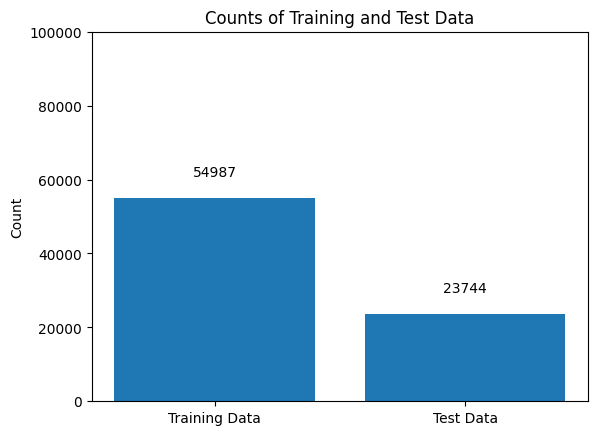

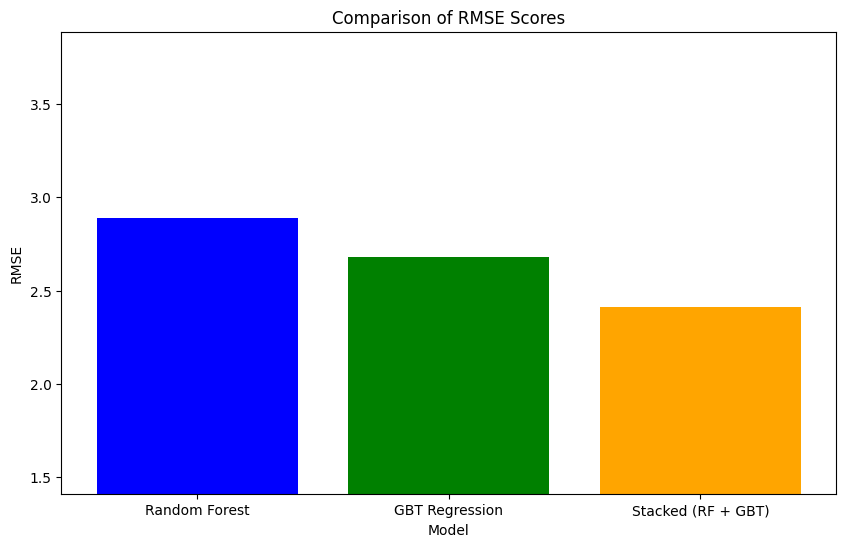

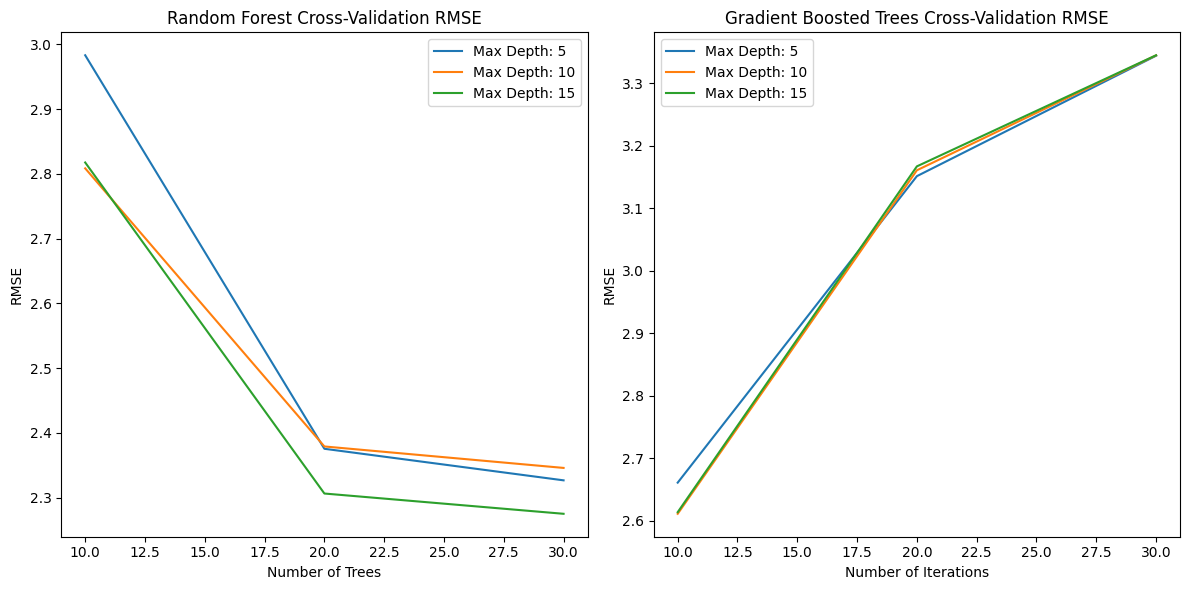

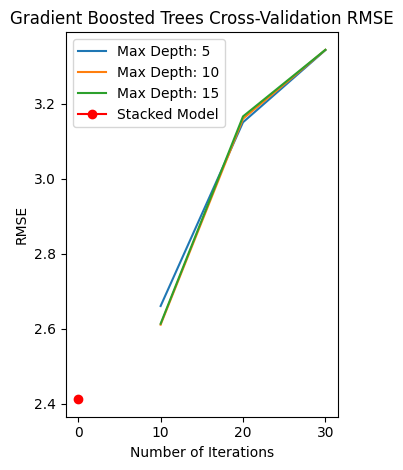

In [ ]:
##1st approach

training_count = train_data.count()
test_count = test_data.count()

# Set upper limit for y-axis
upper_limit = 100000

# Plotting
plt.bar(['Training Data', 'Test Data'], [training_count, test_count])
plt.ylim(0, upper_limit)  # Set upper limit for y-axis

# Add count labels on top of each bar
for i, count in enumerate([training_count, test_count]):
    plt.text(i, count + 5000, str(count), ha='center', va='bottom')

plt.title('Counts of Training and Test Data')
plt.ylabel('Count')
plt.show()

# RMSE scores of the three models
models = ['Random Forest', 'GBT Regression', 'Stacked (RF + GBT)']
rmse_scores = [rf_rmse, gbt_rmse, final_rmse]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_scores, color=['blue', 'green', 'orange'])
plt.title('Comparison of RMSE Scores')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.ylim(min(rmse_scores) - 1, max(rmse_scores) + 1)  # Adjust y-axis limit for better visualization
plt.show()

#learning curve graph
# Extract the RMSE for Random Forest models across different hyperparameters
rf_rmse_values = np.array(rf_cvModel.avgMetrics).reshape((3,3))

# Extract the RMSE for Gradient Boosted Trees models across different hyperparameters
gbt_rmse_values = np.array(gbt_cvModel.avgMetrics).reshape((3,3))

# Define the hyperparameter settings
rf_num_trees = [10, 20, 30]
rf_max_depth = [5, 10, 15]
gbt_max_iter = [10, 20, 30]
gbt_max_depth = [5, 10, 15]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Random Forest RMSE
plt.subplot(1, 2, 1)
for i in range(len(rf_max_depth)):
    plt.plot(rf_num_trees, rf_rmse_values[i], label=f"Max Depth: {rf_max_depth[i]}")
plt.title("Random Forest Cross-Validation RMSE")
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.legend()

# Plot Gradient Boosted Trees RMSE
plt.subplot(1, 2, 2)
for i in range(len(gbt_max_depth)):
    plt.plot(gbt_max_iter, gbt_rmse_values[i], label=f"Max Depth: {gbt_max_depth[i]}")
plt.title("Gradient Boosted Trees Cross-Validation RMSE")
plt.xlabel("Number of Iterations")
plt.ylabel("RMSE")
plt.legend()

plt.tight_layout()
plt.show()

# Add the RMSE value for the stacked model to the plot
plt.subplot(1, 2, 2)
for i in range(len(gbt_max_depth)):
    plt.plot(gbt_max_iter, gbt_rmse_values[i], label=f"Max Depth: {gbt_max_depth[i]}")
plt.plot(final_rmse, marker='o', color='red', label='Stacked Model')
plt.title("Gradient Boosted Trees Cross-Validation RMSE")
plt.xlabel("Number of Iterations")
plt.ylabel("RMSE")
plt.legend()

plt.tight_layout()
plt.show()


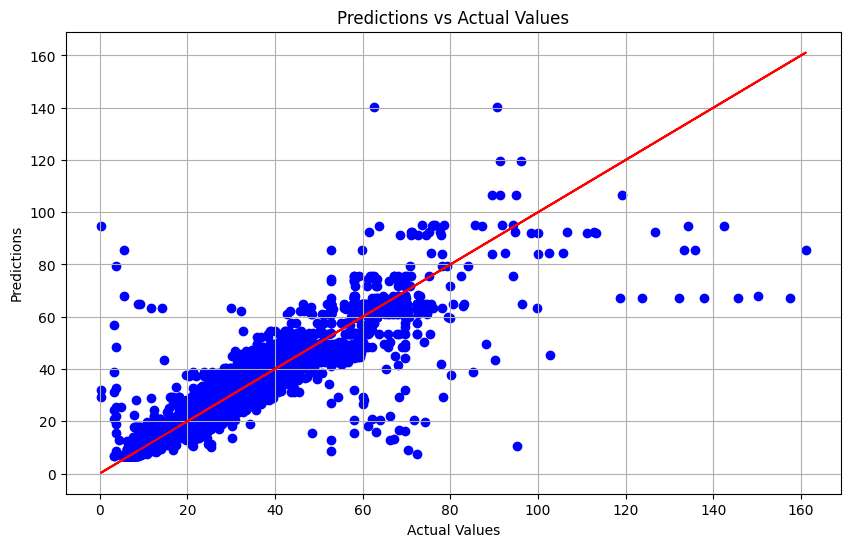

In [ ]:
#2nd approach:

#Convert predictions and actual values to Pandas DataFrame for easier visualization
predictions_pd = predictions.select("prediction").toPandas()
actual_values_pd = predictions.select("total_amount").toPandas()

#Calculate residuals, represent the difference between the observed and predicted values
residuals = actual_values_pd.values.flatten() - predictions_pd.values.flatten()

#Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(actual_values_pd, predictions_pd, color='blue')
plt.plot(actual_values_pd, actual_values_pd, color='red')
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()
